<a href="https://colab.research.google.com/github/Chait314/Parkinsons/blob/main/Parkinsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import seaborn as sns;


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
df = pd.read_csv("/content/drive/MyDrive/parkinsons.data");

In [6]:
print(df.head());

             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.0654

In [8]:
from sklearn.preprocessing import StandardScaler;
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve, precision_score

In [10]:
df = df.sample(frac=1, random_state = 42).reset_index(drop = True);

In [43]:
train_size = int(len(df)*0.7);
test_size = int(len(df)*0.2);
val_size = int(len(df)-train_size-test_size);
train_df = df[:train_size];
test_df = df[train_size: test_size + train_size];
validation_df = df[train_size + test_size: ];

In [30]:
df = df.drop('name', axis=1);

In [31]:
y = df['status'];
X = df.drop('status', axis=1);

In [32]:
scaler = StandardScaler();
X_scaled = scaler.fit_transform(X);

In [33]:
import torch.nn as nn;
import torch.optim as optim;
import torch;

In [68]:
class DNN(nn.Module):
  def __init__(self):
    super().__init__();
    self.flatten = nn.Flatten();
    self.network = nn.Sequential(
        nn.Linear(22, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 1),
        nn.Sigmoid()
    );

  def forward(self, x):
      x = self.flatten(x)
      x = self.network(x)
      return x;

In [69]:
X_tensor = torch.tensor(X_scaled, dtype = torch.float32);
y_tensor = torch.tensor(y, dtype = torch.float32).unsqueeze(1);

In [70]:
from torch.utils.data import DataLoader, TensorDataset, random_split

In [71]:
train_dataset, val_dataset, test_dataset = random_split(
    TensorDataset(X_tensor, y_tensor),
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [72]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset , batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [81]:
model = DNN();
criterion = nn.BCELoss();
optimizer = optim.AdamW(model.parameters(), lr=0.001);
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor=0.5, patience = 5);

In [82]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [87]:
train_losses, val_aucs, val_accs = [], [], []

In [88]:
epochs = 500
best_val_auc = 0;
patience, patience_counter = 20, 0

for epoch in range(epochs):
  model.train();
  train_loss = 0;
  for x_batch, y_batch in train_loader:
    optimizer.zero_grad();
    outputs = model(x_batch);
    loss = criterion(outputs, y_batch);
    loss.backward();
    optimizer.step();
    train_loss += loss.item();

  model.eval();
  y_true, y_pred = [], [];
  with torch.no_grad():
      for x_val, y_val in val_loader:
        preds = model(x_val);
        y_true.extend(y_val.numpy());
        y_pred.extend(preds.numpy());

  y_pred = np.array(y_pred);
  val_auc = roc_auc_score(y_true, y_pred);
  val_acc = accuracy_score(y_true, (y_pred > 0.5).astype(int));
  train_losses.append(train_loss/len(train_loader));
  val_aucs.append(val_auc);
  val_accs.append(val_acc);
  scheduler.step(val_auc);


  if val_auc > best_val_auc:
    best_val_auc = val_auc;
    patience_counter = 0;
    torch.save(model.state_dict(), "best_model.pth");
  else:
    patience_counter += 1
    if patience_counter >= patience:
      print(f"Early stopping at epoch {epoch+1}");
      break;

Early stopping at epoch 21


In [89]:
model.eval();

In [90]:
y_true, y_pred = [], [];

with torch.no_grad():
  for X_test, y_test in test_loader:
    preds = model(X_test);
    y_true.extend(y_test.numpy());
    y_pred.extend(preds.numpy());

y_pred = np.array(y_pred)
test_auc = roc_auc_score(y_true, y_pred)
test_acc = accuracy_score(y_true, (y_pred > 0.5).astype(int))

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Test Accuracy: 0.9487
Test AUC: 0.9586


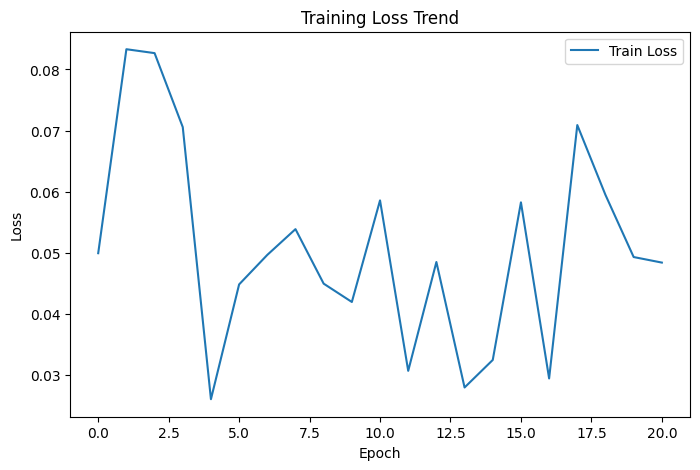

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


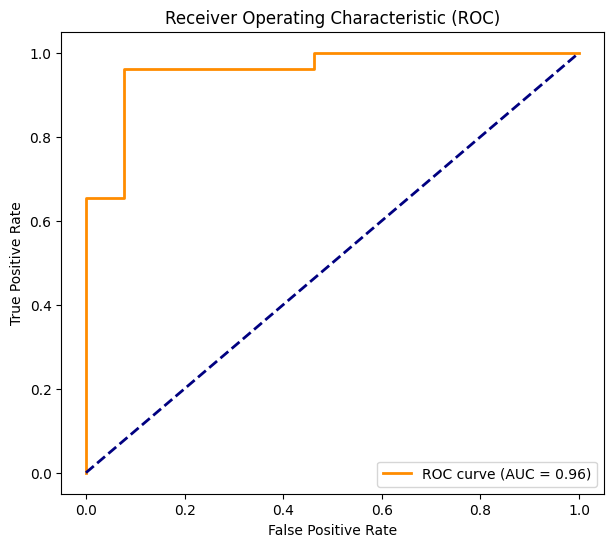

In [94]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()